# Retro — Figure 2


In [1]:
import os
import fsspec
import json
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

## Load the data


In [2]:
with fsspec.open(
    "https://carbonplan.blob.core.windows.net/carbonplan-retro/projects/retro-db-light-v1.0.json",
    "r",
) as f:
    db = json.load(f)
db = list(filter(lambda x: ~(x["id"] == "ACR360") & ~(x["id"] == "CAR1102"), db))

In [3]:
projects = [
    project
    for project in db
    if project["carbon"]["initial_carbon_stock"]["value"]
    > project["carbon"]["common_practice"]["value"]
]

In [4]:
def get_summary_stats(data):
    summary_d = {}
    mod = smf.ols("cp~average_slag_baseline", data=data).fit()
    summary_d["slope"] = mod.params["average_slag_baseline"]

    delta_slag = data["average_slag_baseline"] - data["cp"]
    desc = delta_slag.describe()
    summary_d["median_delta"] = desc["50%"]
    summary_d["mean_delta"] = desc["mean"]
    return summary_d

Organize into a data frame


In [5]:
df = pd.DataFrame(
    {
        project["opr_id"]: (
            project["carbon"]["average_slag_baseline"]["value"],
            project["carbon"]["common_practice"]["value"],
        )
        for project in projects
    }
).T.rename(columns={0: "average_slag_baseline", 1: "cp"})

In [6]:
df = df.dropna()

In [7]:
df.sort_values(by=["cp"], inplace=True, ascending=False)

## Make the plot


In [8]:
np.sum(df["average_slag_baseline"] < 1.05 * df["cp"]) / len(df)

0.8923076923076924

In [9]:
np.mean(df["average_slag_baseline"] - df["cp"])

1.983846153846154

In [10]:
np.median(df["average_slag_baseline"] - df["cp"])

0.0

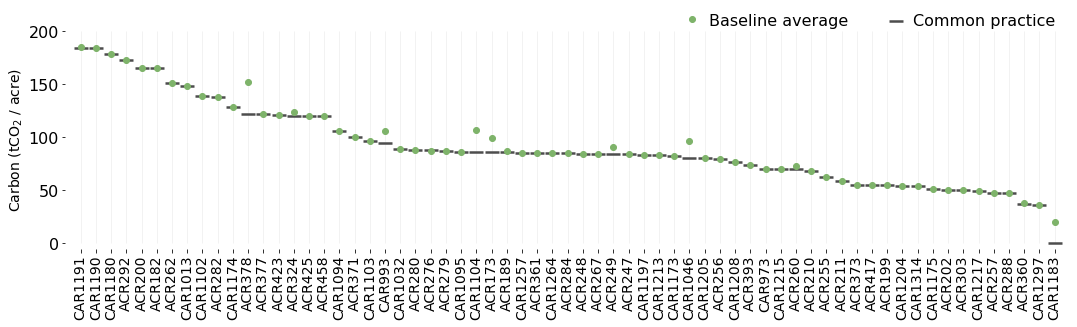

In [11]:
plt.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
ax.vlines(df.index.values, 0, 200, color=(0.95, 0.95, 0.95), linewidth=1)
ax.scatter(
    df.index.values,
    df["cp"],
    marker="_",
    s=200,
    color=".3",
    lw=2.5,
    label="Common practice",
    zorder=10,
)
ax.plot(
    df.index.values,
    df["average_slag_baseline"],
    ".",
    markersize=12,
    color="#7EB36A",
    label="Baseline average",
    zorder=11,
)
ax.set_ylim(-5, 200)
ax.set_xticks(df.index.values)
ax.set_xticklabels(df.index.values, rotation="vertical")
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(-1, 65)
ax.spines["bottom"].set_visible(False)
ax.tick_params(axis="y", which="major", pad=3, labelsize=16)
ax.tick_params(axis="x", which="major", pad=3)

ax.set_ylabel("Carbon (tCO$_2$ / acre)")

plt.legend(
    ncol=2,
    loc="upper right",
    frameon=False,
    bbox_to_anchor=(1, 1.15),
    handletextpad=0.05,
    prop={"size": 16},
)

fname = "Figure-2.svg"
if "BLOB_ACCOUNT_KEY" in os.environ:
    with fsspec.open(
        f"az://carbonplan-retro/figures/raw/{fname}",
        "w",
        account_name="carbonplan",
        account_key=os.environ["BLOB_ACCOUNT_KEY"],
    ) as f:
        fig.savefig(f, format="svg")
else:
    plt.savefig(fname)